# 75.26 Modelos y Simulación

# Trabajo Práctico 2

## Grupo 2

### Alumnos:

- Duzac, Emilia
- Belletti, Gabriel Ignacio
- Vazquez, Nicolás Alberto
- Cohen, Martín
-
### Generador de números aleatorios elegido: [MIXMAX](http://arxiv.org/pdf/1403.5355)

## Ejercicio 2

### método asignado en la planilla de grupos: SIMPY

Una entidad financiera está analizando cambiar uno de sus cajeros automáticos por uno con la funcionalidad de reciclador
de billetes (si un cliente realiza un depósito de efectivo, ese efectivo estará disponible para que lo pueda retirar otro cliente).
El cajero automático actual, que se quiere reemplazar, es de tipo estándar. No recicla los billetes, sino que posee dos
compartimentos, uno con dinero para entregar y otro donde guarda el dinero que se deposita.
Esto presenta los siguientes problemas:

- Si no tiene más efectivo para entregar en el compartimento de retiro de dinero, no entrega efectivo, aunque tenga en el compartimento de depósitos.
- Si el compartimento que recibe los depósitos se completa, no puede recibir más.

La entidad conoce que con el cajero actual el 25% de los clientes se retiraba sin poder extraer dinero, y sólo acepta cambiarlo si este porcentaje disminuye.

Por simplicidad suponer que el cajero sólo expende billetes de una denominación, tiene una capacidad máxima de 2000
billetes, y comienza el día con su carga completa.

En el relevamiento que realizó la entidad diferenció a sus clientes en dos grupos:

- Grupo 1: Sólo retiran efectivo, y corresponden al 75% de los clientes que arriban El tiempo que utilizan el cajero se puede modelar con una distribución exponencial de media 90 segundos. Cada cliente de este grupo, extrae una cantidad de billetes que sigue una distribución uniforme $[3,50]$.
- Grupo 2: Sólo realizan depósitos, son el 25% de los clientes totales. Utilizando el cajero un tiempo que siguen una distribución exponencial de media 5 minutos ($5min = 300seg$). Cada cliente de este grupo, deposita una cantidad de billetes que se puede modelar utilizando una distribución uniforme $[10,110]$.

El área a cargo de modelar el problema, propuso un tiempo de arribo de clientes que sigue una distribución de
probabilidades Exponencial con media = 180 seg

### Se pide:

1. Simular, utilizando el generador de números al azar desarrollado en el tp 1, 100 días completos de 24 hrs,
independientes. (utilizando distintas semillas en el generador).
2. Graficar la cantidad media de billetes disponibles en el cajero luego de cada transacción.
3. Graficar la distribución de los tiempos que los clientes demoran en el sistema (espera + utilización del cajero).
4. Calcular el tiempo medio y el desvío estandar del tiempo que los clientes demoran en el Sistema.
5. Proponer otras frecuencias de arribos de clientes y comprar los resultados obtenidos.

### Consideraciones/Suposiciones

- El cajero solo admite billetes de una denominacion por lo que se hablara de cantidad de billetes en lugar del monto representado por estos.

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import simpy
import threading

In [2]:
from MixMax import MixmaxRNG

### Constantes

In [3]:
# cantidad de dias simulados
TOTAL_SIMULATIONS = 100
# tiempo total del dia para recarga de efectivo (cada dia se recarga el efectivo) 3600 * 24 = 86 400
DAY_TIME = 86400.0
# arribo de clientes 1 cliente cada 180s (de media) equivale a 1/180 clientes/s
ARRIVAL_CLIENT = 1.0/180.0

# GRUPO 1 retiro de efectivo
# proporcion de grupo 1
PROPORTION_GROUP_1 = 0.75
# intervalo de valores posibles de extraccion (cantidad de billetes que se extraen)
EXTRACTION_INTERVAL = (3, 50)
# tiempo de uso del cajero
TIME_LAMBDA_GROUP_1 = 1/90

# GRUPO 2 ingreso de efectivo
# intervalo de valores posibles de deposito (cantidad de billetes que se depositan)
DEPOSIT_INTERVAL = (10, 110)
# tiempo de uso del cajero
TIME_LAMBDA_GROUP_2 = 1/300

# capacidad maxima de billetes del cajero
MAX_AMOUNT_OF_BILLS = 2000

# semillas
# semilla de arrivos
SEED_ARRIVALS = 1235
# semilla base de clientes
SEED_CLIENT_TIPE = 785

# cantidad de cajeros disponibles
NUMBER_OF_CASHIERS = 1

# proporcion de extracciones fallidas antes
EXTRACTION_FAILURE_OLD = 0.25

### Codigo

In [4]:
class DailyCustomerEvent:
    def __init__(self):
        self.time_delay = []
        self.n_bills = []
        self.n_extraction_failure = 0.0
        self.extraction_attempts = 0.0
        self.time_delay_extraction = []
        self.time_delay_deposit = []

    def extraction(self, rest, time, is_failure):
        self.extraction_attempts += 1.0
        if is_failure:
            self.n_extraction_failure += 1.0
        self.time_delay.append(time)
        self.n_bills.append(rest)
        self.time_delay_extraction.append(time)

    def income(self, rest, time):
        self.time_delay.append(time)
        self.n_bills.append(rest)
        self.time_delay_deposit.append(time)

    def median_bills(self):
        # caso en donde nadie hizo transaccion el cajero esta completo
        if len(self.n_bills) == 0:
            return 2000.0
        return np.median(self.n_bills)

    def time_median_and_std(self):
        # caso en donde nadie hizo transaccion
        if len(self.time_delay) == 0:
            return 0, 0
        median = np.median(self.time_delay)
        std = np.std(self.time_delay)
        return median, std

    def time_of_extraction_median_and_std(self):
        # caso en donde nadie hizo transaccion
        if len(self.time_delay_extraction) == 0:
            return 0, 0
        median = np.median(self.time_delay_extraction)
        std = np.std(self.time_delay_extraction)
        return median, std

    def time_deposit_median_and_std(self):
        # caso en donde nadie hizo transaccion
        if len(self.time_delay_deposit) == 0:
            return 0, 0
        median = np.median(self.time_delay_deposit)
        std = np.std(self.time_delay_deposit)
        return median, std

    """Returns the number of extraction failures divided by the number of extractions.
    Case where there have been no extractions returns zero."""
    def extraction_failure(self):
        if self.extraction_attempts == 0 or self.n_extraction_failure == 0:
            return 0
        extraction_failure_proportion = self.n_extraction_failure / self.extraction_attempts
        return extraction_failure_proportion


In [5]:
def exponencial(val_p, value_lambda):
    return -(np.log(1 - val_p)) / value_lambda

"""returns a list with the time of arrivals (not accumulated), up to the given maximum time."""
def generate_arrivals(seed, total_seconds, value_lambda):
    result = []
    total = 0.0
    # generador de numeros aleatorios
    random = MixmaxRNG(seed)
    while True:
        # nuevo arribo en segundos
        exp = exponencial(random.generate_number(), value_lambda)
        # tiempo acumulado de arribo
        total += exp
        # caso donde se pasa del tiempo maximo corta el bucle
        if total > total_seconds:
            break
        # se agrega el tiempo entre arrivos (NO acumulado)
        result.append(exp)
    return result

In [6]:
"""returns true if, according to the given value, it belongs to group 1."""
def is_group_1(p_val):
    return p_val < PROPORTION_GROUP_1

"""client withdrawing money."""
def client_group_1(env, cashier, random, res_cashier, arrival_time, statistics, debug):
    # generan el valor de la cantidad de billetes que usaran (extraer)
    extraction = int(round(random.generate_number(interval=EXTRACTION_INTERVAL), 0))
    # tiempo que nesesito para realizar la operacion
    time = exponencial(random.generate_number(), TIME_LAMBDA_GROUP_1)
    with res_cashier.request() as req:
        yield req
        if debug:
            print(f'{env.now:7.3f} s: Extraction of {extraction} begins.')
        # caso donde hay dinero para extraer
        permission = cashier.level >= extraction
        if permission:
            cashier.get(extraction)
        # consume tiempo manteniendo el recurso para si
        yield env.timeout(delay=time)
        if debug:
            print(f'{env.now:7.3f} s: Correct extraction {permission}.', )
        statistics.extraction(cashier.level, env.now - arrival_time, not permission)
    return

"""customer depositing money."""
def client_group_2(env, cashier, random, res_cashier, arrival_time, statistics, debug):
    # generan el valor de la cantidad de billetes que usaran (depositar)
    deposit = int(round(random.generate_number(interval=DEPOSIT_INTERVAL), 0))
    # tiempo que nesesito para realizar la operacion
    time = exponencial(random.generate_number(), TIME_LAMBDA_GROUP_2)
    with res_cashier.request() as req:
        yield req
        if debug:
            print(f'{env.now:7.3f} s: Deposit of {deposit} begins.')
        # caso donde hay espacio para depositar dinero
        permission = cashier.level + deposit <= MAX_AMOUNT_OF_BILLS
        if permission:
            cashier.put(deposit)
        # consume tiempo manteniendo el recurso para si
        yield env.timeout(delay=time)
        if debug:
            print(f'{env.now:7.3f} s: Correct deposit {permission}.')
        statistics.income(cashier.level, env.now - arrival_time)
    return

""""""
def client(env, list_arrivals_of_clients, seed, cashier, res_cashier, statistics, debug):
    random = MixmaxRNG(seed)
    # para cada arrivo se clasifica en los dos grupos
    if debug:
        print(f'{env.now:7.3f} s: Clients arrivals begins.')
    for delay in list_arrivals_of_clients:
        # pasa un tiempo antes del evento
        yield env.timeout(delay=delay)
        arrival_time = env.now
        if debug:
            print(f'{arrival_time:7.3f} s: Arrived new client.')
        # se toma un numero al azar (uniforme) para saber en que grupo caen
        p_val = random.generate_number()
        if is_group_1(p_val):
            env.process(client_group_1(env, cashier, random, res_cashier, arrival_time, statistics, debug))
        else:
            env.process(client_group_2(env, cashier, random, res_cashier, arrival_time, statistics, debug))
    if debug:
        print(f'{env.now:7.3f} s: Clients arrivals finish.')

In [7]:
def daily_simulation(seed_arrivals=SEED_ARRIVALS, seed_clients=SEED_CLIENT_TIPE, arrival_client=ARRIVAL_CLIENT, total_time=DAY_TIME, debug=False):
    # estadisticas de la simulacion
    statistics = DailyCustomerEvent()
    # creacion del entorno simpy
    env = simpy.Environment()
    # creacion de recurso de cajero (contiene billetes) (inicia con la maxima cantidad de billetes)
    cashier = simpy.Container(env, MAX_AMOUNT_OF_BILLS, init=MAX_AMOUNT_OF_BILLS)
    # cantidad de recurso cajero disponible
    res_cashier = simpy.Resource(env, NUMBER_OF_CASHIERS)
    # llegada de clientes
    arrivals_of_clients = generate_arrivals(seed_arrivals, total_time, arrival_client)
    # procesado de clientes
    proc = env.process(client(env, arrivals_of_clients, seed_clients, cashier, res_cashier, statistics, debug))
    env.run(until=proc)
    return statistics

stats = daily_simulation(total_time=600.0, debug=True, arrival_client=1/60)
print("Median n bills: ", stats.median_bills(),
      "\nMedian;std of all time: ", stats.time_median_and_std(),
      "\nMedian;std of time (only deposits): ", stats.time_deposit_median_and_std(),
      "\nMedian;std of time (only extractions): ", stats.time_of_extraction_median_and_std(),
      "\nFailure extraction proportion: ", stats.extraction_failure())

  0.000 s: Clients arrivals begins.
 40.164 s: Arrived new client.
 40.164 s: Extraction of 48 begins.
 65.897 s: Arrived new client.
103.944 s: Arrived new client.
123.355 s: Correct extraction True.
123.355 s: Extraction of 28 begins.
175.393 s: Arrived new client.
192.105 s: Correct extraction True.
192.105 s: Extraction of 7 begins.
220.546 s: Correct extraction True.
220.546 s: Extraction of 8 begins.
303.350 s: Arrived new client.
307.565 s: Arrived new client.
349.824 s: Arrived new client.
382.132 s: Arrived new client.
411.433 s: Correct extraction True.
411.433 s: Extraction of 46 begins.
427.199 s: Arrived new client.
495.180 s: Arrived new client.
499.079 s: Arrived new client.
499.079 s: Clients arrivals finish.
Median n bills:  1920.5 
Median;std of all time:  (121.40492082637331, 57.418650120008756) 
Median;std of time (only deposits):  (0, 0) 
Median;std of time (only extractions):  (121.40492082637331, 57.418650120008756) 
Failure extraction proportion:  0


In [ ]:
def wrapper_daily_simulation(vec, pos, seed_arrivals=SEED_ARRIVALS, seed_clients=SEED_CLIENT_TIPE, arrival_client=ARRIVAL_CLIENT, total_time=DAY_TIME, debug=False):
    vec[pos] = daily_simulation(seed_arrivals=seed_arrivals, seed_clients=seed_clients, arrival_client=arrival_client, total_time=total_time, debug=debug)

def simulaction(total_simulations=TOTAL_SIMULATIONS, seed_base_arrivals=SEED_ARRIVALS, seed_base_clients=SEED_CLIENT_TIPE, arrival_client=ARRIVAL_CLIENT, total_time=DAY_TIME, debug=False):
    # lista de estadisticas de resultados
    result_of_simulations = [None] * total_simulations
    # aplico un modelo fork-join donde separo cada simulacion independiente en un hil diferente.
    threads = [None] * total_simulations
    total_range = range(total_simulations)
    for n_simulation in total_range:
        # actualizo la semilla de arrivos
        seed_arrivals = seed_base_arrivals + n_simulation
        # actualizo la semilla de clientes
        seed_clients = seed_base_clients + n_simulation
        simulation_lambda = lambda vec, pos: wrapper_daily_simulation(vec, pos, seed_arrivals=seed_arrivals, seed_clients=seed_clients, arrival_client=arrival_client, total_time=total_time, debug=debug)
        threads[n_simulation] = threading.Thread(target=simulation_lambda, args=(result_of_simulations, n_simulation))
        threads[n_simulation].start()
    for n_simulation in total_range:
        threads[n_simulation].join()
    return result_of_simulations

stats_all = simulaction(total_time=180.0, debug=True, arrival_client=1/30, total_simulations=10)
print("number of results equal to number of simulations: ", len(stats_all)==10,
      "\nMedian n bills: ", list(map(lambda x: x is None, stats_all)),
      "\nMedian n bills: ", list(map(lambda x: x.median_bills(), stats_all)),
      "\nFailure extraction proportion: ", list(map(lambda x: x.extraction_failure(), stats_all)))

In [9]:
# corro la simulacion completa
complete_simulation = simulaction()
print(len(complete_simulation) == TOTAL_SIMULATIONS)

True


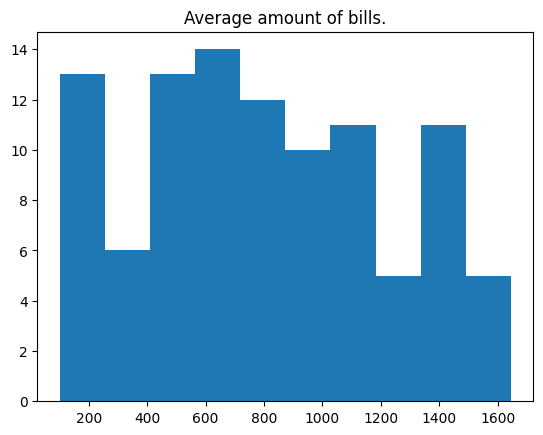

In [11]:
def plot_median_bills(all_simu):
    values = list(map(lambda x: x.median_bills(), all_simu))
    plt.hist(values)
    plt.title('Average amount of bills.')
    plt.show()

plot_median_bills(complete_simulation)

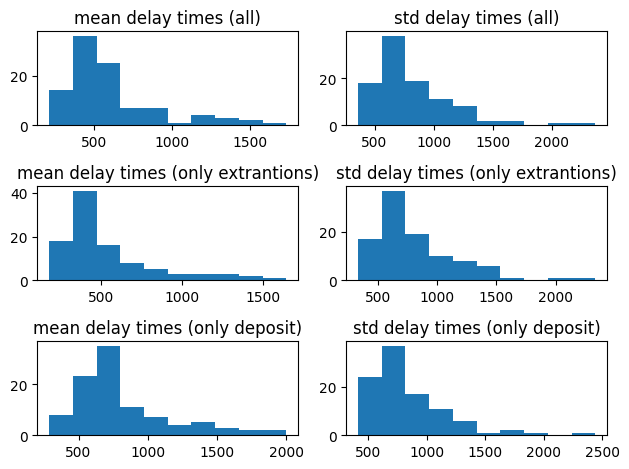

In [14]:
def plot_delay_times(all_simu):
    # Separo los 6 graficos de tiempo de espera
    # Cada fila es un tiempo diferente, cada columna es media o desviacion
    fig, axs = plt.subplots(nrows=3, ncols=2)
    # delay = tiempo de espera + tiempo de uso
    # all = extration + deposit

    # all
    # mediana
    values_median_all = list(map(lambda x: x.time_median_and_std()[0], all_simu))
    axs[0, 0].hist(values_median_all)
    axs[0, 0].set_title('mean delay times (all)')
    # desvio
    values_std_all = list(map(lambda x: x.time_median_and_std()[1], all_simu))
    axs[0, 1].hist(values_std_all)
    axs[0, 1].set_title('std delay times (all)')

    # extraciones
    # mediana
    values_median_extract = list(map(lambda x: x.time_of_extraction_median_and_std()[0], all_simu))
    axs[1, 0].hist(values_median_extract)
    axs[1, 0].set_title('mean delay times (only extrantions)')
    # desvio
    values_std_extract = list(map(lambda x: x.time_of_extraction_median_and_std()[1], all_simu))
    axs[1, 1].hist(values_std_extract)
    axs[1, 1].set_title('std delay times (only extrantions)')
    fig.tight_layout()

    # Depositos
    # mediana
    values_median_deposit = list(map(lambda x: x.time_deposit_median_and_std()[0], all_simu))
    axs[2, 0].hist(values_median_deposit)
    axs[2, 0].set_title('mean delay times (only deposit)')
    # desvio
    values_std_deposit = list(map(lambda x: x.time_deposit_median_and_std()[1], all_simu))
    axs[2, 1].hist(values_std_deposit)
    axs[2, 1].set_title('std delay times (only deposit)')
    fig.tight_layout()
    plt.show()

    return values_median_all, values_std_all, values_median_extract, values_std_extract, values_median_deposit, values_std_deposit

res_times_simu_1 = plot_delay_times(complete_simulation)

In [21]:
""""""
def proportion_of_not_failure(all_simu, max_proportion_failure=EXTRACTION_FAILURE_OLD):
    # comparo si la cantidad de fallas es menor a la "aceptada" para cambiar el cajero
    l = list(map(lambda x: x.extraction_failure()<max_proportion_failure, all_simu))
    ok = 0.0
    for f in l:
        if f:
            ok += 1.0
    # retorno la proporcion que logra cumplir con la condicion para ser "aceptada"
    return ok / len(l)
    
proportion_of_not_failure(complete_simulation)

1.0

In [15]:
# corro la simulacion completa con otra cantidad de arrivos
# tomo el doble de arrivos clientes
complete_simulation_2 = simulaction(arrival_client=ARRIVAL_CLIENT*2)
print(len(complete_simulation_2) == TOTAL_SIMULATIONS)

True


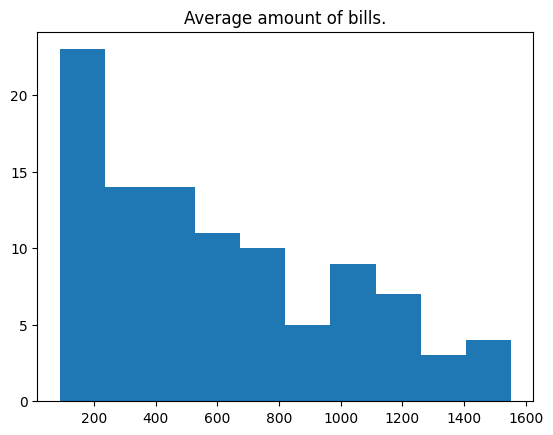

In [16]:
plot_median_bills(complete_simulation_2)

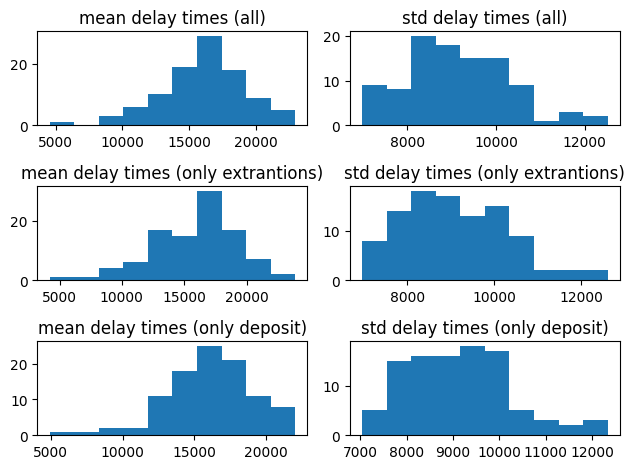

In [17]:
res_times_simu_2 = plot_delay_times(complete_simulation_2)

In [22]:
proportion_of_not_failure(complete_simulation_2)

1.0